Please use the Local ./Dockerfile environment 

In [1]:
# install the faiss-cpu when new env is provisioned
#!pip install faiss-cpu
#conda install -c pytorch faiss-cpu=1.7.4 mkl=2021

In [2]:
# install the openai when new env is provisioned
#!pip install openai

#conda install -c conda-forge openai

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import umap
import faiss
import openai
import pandas as pd
import numpy as np
import altair as alt
import configparser
#from sklearn import decomposition


#alt.data_transformers.disable_max_rows()

In [4]:
# Optional in Jupyter Notebook: requires an up-to-date vega nbextension.
#alt.renderers.enable('png')

In [5]:
pd.__version__

'1.5.3'

In [6]:
# make sure we are using FAISS version 1.7.4 
faiss.__version__

'1.7.4'

### Prepare required resources

In [7]:
# This dataframe is created with the amazon_reviews_us_Apparel_v1_00.tsv.gz dataset with following filtering criteria:
# 1. Year 2015
# 2. Products with 15 - 25 reviews
# 3. review_lenght > 10

df_apparel = pd.read_csv('../resources/data/apparel_10to14.tsv.gz', sep='\t', compression='gzip')
cols = ['product_id', 'review_id', 'star_rating', 'product_title', 'review_body']
df_apparel = df_apparel[cols]
df_apparel.head(3)

,product_id,review_id,star_rating,product_title,review_body
0,B00001QHXX,R2HBUQ97RV5JVR,3.0,Richard Nixon Mask,I got this mask for a company party and it fre...
1,B00001QHXX,RHCH92YNAS282,4.0,Richard Nixon Mask,"Nice mask, will have to do some fitting work. ..."
2,B00001QHXX,R1OHYB07D0WE35,5.0,Richard Nixon Mask,"Even though its a bit large, I can't help but ..."


In [8]:
# Load the pre-created FAISS index
faiss_index = faiss.read_index('../resources/binary/apparel_10to14_review_cosine.faissindex')

In [9]:
# Load your API key from an environment variable or secret management service
config = configparser.ConfigParser()
config.read('nes.ini')
openai.api_key = config['OpenAI']['api_key']

### Define helper functions

In [10]:
# Helper function to create the query embedding. Make sure to use the same model as what we used to created the product embedding
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   
   return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'], dtype='float32').reshape(1, -1)

In [11]:
def search_with_original_query(df, faiss_index, query_embedding, num_of_records=100):
    # we need to normalize the question embedding in order to use cosine similarity to search 
    faiss.normalize_L2(query_embedding)

    # distance is the correspnding distance
    # result_idx is the index of the input array, hence the index of the dataframe (if the dataframe index is reset which starts with 0)
    distance, result_idx = faiss_index.search(query_embedding, k=num_of_records)

    # use the return index to create the result dataframe
    df_result = df.iloc[result_idx.squeeze().tolist()]
    # add Distance to the result dataframe
    df_result['distance'] = distance.T

    df_result = df_result.sort_values(by='distance', ascending=True)
    
    return df_result, result_idx

In [12]:
prompt_rewrite ="""
    You are an English teacher. You need to find every single adjective from the sentences delimited by triple backquotes below.
    Then you rewrite the sentences by changing the adjectives in their opposite meaning. 
    Finally, you only need to output the rewritten sentences.

    ```{}```
"""

prompt_antonym="""
    You are an English teacher. You need to find every single ADJECTIVE from the sentences delimited by triple backquotes below.
    Then, you transform every adjective into its antonym.
    Finally, give the dictionary meaning for each antonym.
    Below are two examples. You need to comlete the third one. 
    

    Text 1: Kids flip flops for girl, cute, good fit, comfortable and durable, low price
    Output 1: Artless means without guile or deception. Unsuited means not proper or fitting for something. Uncomfortable means causing discomfort.  Fragile means easily broken. Costly means expensive.
    ## 
    Text 2: Long sleeve shirts for men. Wrinkle-free, thick but breathable and slim fit
    Output 2: Short means having little length. Crinkle means to form many short bends or ripples. Thin means measuring little in cross section or diameter. Airtight means impermeable to air or nearly so. Wide means having a greater than usual measure across
    ##
    Text 3:  ```{}```
    Output 3:
"""

In [13]:
def generate_opposite_query(orignal_query='', prompt=''):

    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt.format(orignal_query),
        temperature=0,
        max_tokens=1000,
        frequency_penalty=0.0,
        presence_penalty=0.0
    )

    return response['choices'][0]['text']

In [14]:
def search_with_opposite_query(df, faiss_index, opposite_query_embedding, original_query_result_index, num_of_records=100):

    faiss.normalize_L2(opposite_query_embedding)

    # we want to make sure the opposite query only compare against the texts found by the original query 
    id_selector = faiss.IDSelectorArray(original_query_result_index.shape[1], faiss.swig_ptr(original_query_result_index))
    filtered_distances, filtered_indices = faiss_index.search(opposite_query_embedding, k=num_of_records, params=faiss.SearchParametersIVF(sel=id_selector))

    df_opposite_result = df.iloc[filtered_indices.squeeze().tolist()]
    df_opposite_result['distance'] = filtered_distances.T

    df_opposite_result = df_opposite_result.sort_values(by='distance', ascending=False)

    return df_opposite_result

In [15]:
def get_reconcile_result(df_result_original, df_result_opposite):

    df_reconcile_result = df_result_original.merge(df_result_opposite[['review_id', 'distance']], 
                            left_on='review_id', right_on='review_id', how='left', suffixes=('_original', '_opposite'))
    
    # Using Dot Product FAISS Index with L2 normaliztion, the returning result is Cosine Similiarty, rather than Distance.
    # There will turn the Cosine Similarity to Distance 
    df_reconcile_result['distance_original'] = 1 - df_reconcile_result['distance_original']
    df_reconcile_result['distance_opposite'] = 1 - df_reconcile_result['distance_opposite']

    return df_reconcile_result

In [16]:
# Helper function to clip the distance_opposite

def clip_distance_opposite(df, clipping=0.5):
    df = df.sort_values(by='distance_opposite', ascending=False).reset_index(drop=True)
    # Flatten the first n% with distance_opposite sorted in descending order  
    quantile_value = df['distance_opposite'].quantile(q=(1-clipping))
    df.loc[0:(clipping * len(df)), ['distance_opposite']] = quantile_value

    return df

In [17]:
# Helper function to calculate adjsuted distance using the distance_oppsite as a penalty term

def cal_adjusted_distance(df, k=0.5):
    df['distance_adjusted'] = df.apply(lambda row: row['distance_original'] + (k * 1/row['distance_opposite']), axis='columns')
    
    return df 


In [18]:
# Helper function to calculate review level similarity scores

def cal_review_similarity_score(df):
    # find max of distance_adjusted  
    max_distance_adjusted  = df['distance_adjusted'].max()
    # normalized adjusted distance then subtract from 1 to calculate the similarity score 
    df['similarity_score'] = df['distance_adjusted'].apply(lambda x: 1 - x / max_distance_adjusted)

    return df 

In [19]:
# Helper function to calculate the product level similarity scores 

def cal_product_similarity_score(df, method='discount_reward'):

    if method == 'average':
        df_temp = df.groupby('product_id')['similarity_score'].mean()
        df_temp = df_temp.to_frame(name='product_similarity_score').reset_index()
        df = pd.merge(df, df_temp, left_on='product_id', right_on='product_id')
    else:
        df_grouped = df.groupby(by='product_id')

        for name, data in df_grouped:
            data = data.sort_values('similarity_score', ascending=False)
            scores = []
            for cnt, (index, row) in enumerate(data.iterrows()):
                discounted_score = row['similarity_score'] / pow(2, cnt)
                scores.append(discounted_score)
            df.loc[data.index, 'product_similarity_score'] = sum(scores)
        
    df = df.sort_values(by=['product_similarity_score', 'similarity_score'], ascending=[False, False])

    return df

In [20]:
def get_final_search_result(df_reconcile_result, clipping=0, weight=0, method='discount_reward'):
    """
    Method 1:   Calculate product level similarity score by Average
                clipping=0, weight=0, method='average'

    Method 2:   Calculate product level similarity score by Discount Reward
                clipping=0, weight=0, method='discount_reward' 

    Method 3:   Calcuate product level similarity score by Discount Reward with Adjustment by Opposite Query 
                clipping=0.1, weight=0.5, method='discount_reward
    """

    df_copy = df_reconcile_result.copy()

    df_copy = clip_distance_opposite(df_copy, clipping=clipping)
    df_copy = cal_adjusted_distance(df_copy, k=weight)
    df_copy = cal_review_similarity_score(df_copy)
    df_copy = cal_product_similarity_score(df_copy, method=method)

    # re-arrange columns for output
    cols = ['product_id', 'review_id', 'star_rating', 'distance_original', 'distance_opposite',
            'distance_adjusted', 'similarity_score', 'product_similarity_score', 'product_title', 'review_body']

    df_copy = df_copy[cols]

    return df_copy

### Geneate results

In [21]:
df_adj = pd.DataFrame(['Long','Short','Thin','Thick','Breathable','Stuffy','Cool','Hot'], columns=['adjective'])

In [22]:
df_adj['embedding'] = df_adj['adjective'].apply(lambda x: get_embedding(x)[0])

In [23]:
df_adj

,adjective,embedding
0,Long,"[0.0048255734, 0.0027919388, 0.016544823, -0.0..."
1,Short,"[-0.012126952, 0.007962921, 0.012976611, -0.00..."
2,Thin,"[-0.012029518, -0.005202453, 0.0058670673, 0.0..."
3,Thick,"[-0.015147983, -0.008822895, -0.0086416025, -0..."
4,Breathable,"[-0.010360341, 0.012756744, -0.011476474, -0.0..."
5,Stuffy,"[-0.0042448253, -0.010555807, -0.008107787, -0..."
6,Cool,"[-0.009752826, -0.005435001, 0.015460701, -0.0..."
7,Hot,"[-0.028340444, -0.0046487427, -0.0106000975, -..."


### UAMP

In [24]:
# make a func to handle the mixed- type data and return the final UMAP embeddings
def umap_embed(df, n_components=2,  n_neighbors= 15, random_state=42):
    #reducer = umap.UMAP(random_state=RAMDOM_STATE, n_components=2, metric='cosine', n_neighbors=10)
    reducer = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors, metric='cosine')
    #reducer = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors)
    reducer.fit(df)
    umap_embedding = reducer.transform(df)
   
    return reducer, umap_embedding

In [25]:
def gen_dataframe_for_vis(umap_embedding):

    df = pd.DataFrame(umap_embedding)
    df.index.name='Review'
    df = df.reset_index()
    df.columns = [str(c) for c in df.columns]
    df = df.melt(id_vars=['Review'])
    df['variable'] = df['variable'].astype('int64')

    return df


In [26]:
df_adj_vector = pd.DataFrame(df_adj['embedding'].values.tolist()).add_prefix('data')

In [27]:
reducer, umap_adj = umap_embed(df_adj_vector, n_components=2)

In [28]:
umap_adj[:,0]

array([ 9.676306, 10.007706,  9.943519, 10.762296, 11.874402, 11.745523,
       11.543128, 10.712019], dtype=float32)

In [29]:
df_adj['comp1'] = pd.Series(umap_adj[:,0])
df_adj['comp2'] = pd.Series(umap_adj[:,1])

In [30]:
df_adj

,adjective,embedding,comp1,comp2
0,Long,"[0.0048255734, 0.0027919388, 0.016544823, -0.0...",9.676306,3.631436
1,Short,"[-0.012126952, 0.007962921, 0.012976611, -0.00...",10.007706,4.244371
2,Thin,"[-0.012029518, -0.005202453, 0.0058670673, 0.0...",9.943519,5.125019
3,Thick,"[-0.015147983, -0.008822895, -0.0086416025, -0...",10.762296,5.108286
4,Breathable,"[-0.010360341, 0.012756744, -0.011476474, -0.0...",11.874402,5.284543
5,Stuffy,"[-0.0042448253, -0.010555807, -0.008107787, -0...",11.745523,4.619642
6,Cool,"[-0.009752826, -0.005435001, 0.015460701, -0.0...",11.543128,3.783136
7,Hot,"[-0.028340444, -0.0046487427, -0.0106000975, -...",10.712019,3.649359


In [31]:
#df_adj.to_csv('../resources/data/temp/df_adj.csv', index=False)

In [32]:
df_adj = pd.read_csv('../resources/data/temp/df_adj.csv')

In [33]:
annotations = [[0.6, 5.5, 'Breathable'],
               [1.2, 5.0, 'Stuffy'],
               [1.3, 6.3, 'Thick'],
               [1.8, 7.0, 'Thin'],
               [2.0, 3.5, 'Cool'],
               [2.1, 5.5, 'Hot'],
               [2.5, 6.5, 'Short'],
               [3.0, 6.0, 'Long']]
               
df_ann = pd.DataFrame(annotations, columns=['comp1', 'comp2', 'adjective'])

In [34]:
scatter_plot = alt.Chart(data=df_adj).mark_circle(size=200, color='orange').encode(
        x=alt.X('comp1:Q').scale(domain=(0,4)),
        y=alt.Y('comp2:Q').scale(domain=(0,8)),
        tooltip=[
            'adjective:N'
            ]
)

ann_plot = alt.Chart(data=df_ann).mark_text(fontSize=15).encode(
    x=alt.X('comp1:Q'),
    y=alt.Y('comp2:Q'),
    text=alt.Text('adjective:N')
)

plot = (scatter_plot + ann_plot).properties(
    width=600,
    height=400
)

plot.display()

alt.LayerChart(...)

In [35]:
plot.save('scatter.png')

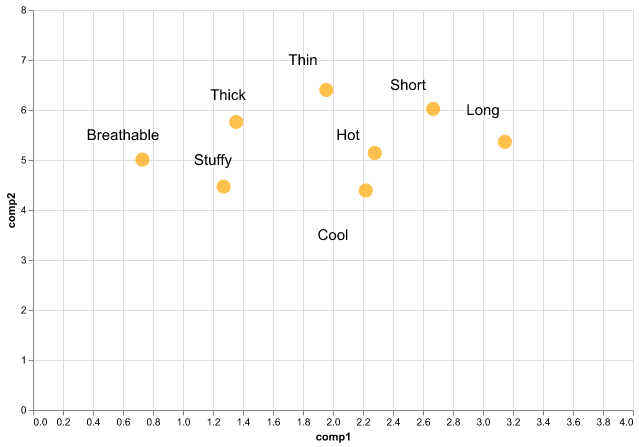

In [37]:
from PIL import Image
Image.open('scatter.png')